# Roman/Rubin Simultaneous Observations

The purpose of this notebook is to explore the feasibilty of simultaneous observations from both the Roman Space Telescope and the Rubin Observatory. 

In [1]:
from os import path
from roman_mission import RomanGalBulgeSurvey
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import rubin_visibility
import rubin_sim.maf as maf
from rubin_sim.utils import (
    hpid2_ra_dec,
    angular_separation,
)
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import interpolate
from datetime import datetime

In [2]:
NSIDE=32

At the time of writing, nominal dates are available for the Roman Galactic Bulge Time Domain Survey (RGBTDS), drawn from [Penny et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJS..241....3P).  So we load these as fixed dates for the time being:

In [3]:
roman_survey = RomanGalBulgeSurvey()
print('Dates of nominal RGBTDS seasons: ')
for season in roman_survey.seasons:
    print(season)

Dates of nominal RGBTDS seasons: 
{'start': <Time object: scale='utc' format='isot' value=2026-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2026-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2026-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2026-10-29T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2027-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2027-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2027-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2027-10-29T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2028-02-12T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2028-04-24T00:00:00.000>}
{'start': <Time object: scale='utc' format='isot' value=2028-09-19T00:00:00.000>, 'end': <Time object: scale='utc' format='isot' value=2028-10-29T00:00:00.000>}


/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Rubin's annual visibility for all points on the sky has been pre-calcuated in the notebook [Rubin Visibility Calculations](https://github.com/LSST-TVSSC/software_tools/blob/main/roman_rubin_overlap/rubin_visibility_calculations.ipynb), so we load that data.  This provides the number of hours each HEALpixel on the sky can be observed for dates throughout the year from the Rubin site.

In [4]:
data_file = '/Users/rstreet1/software/LSST-TVS_software_tools/roman_rubin_overlap/rubin_visibility.hdf5'

with h5py.File(data_file, "r") as f:
    dset = f['healpix']
    healpix = np.array(dset[:])
    
    dset = f['decimalyear']
    dates = np.array(dset[:])
    
    dset = f['visibility_data']
    rubin_visibility = np.array(dset[:])
    
    f.close()

For the purposes of the RGBTDS, we care about a few HEALpix in the central Bulge, so let's identify which HEALpixels those are.

In [5]:
# Location of Roman GBTDS field center
phi = np.deg2rad(roman_survey.bulge_field.ra.deg)
theta = (np.pi/2.0) - np.deg2rad(roman_survey.bulge_field.dec.deg)
xyz = hp.ang2vec(theta, phi)

# Total area expected is ~2sq.deg.  It won't be a round region, but for the sake of estimation, let's assume that it is
radius = np.deg2rad(np.sqrt(2.0/np.pi))

# Select the indices of HEALpixels within this region
bulge_pixels = hp.query_disc(NSIDE, xyz, radius)
bulge_pixels

# Since this is a single pixel at this resolution, handle it as an index to make the code simpler later on
bulge_pixels = bulge_pixels[0]

Since visibility calculations are quite computationally intensive, the pre-calculated data is fairly low resolution, both in time and space, which leads to some artifacts.  Here we can smooth this out, and interpolate. 

In [8]:
from scipy.signal import savgol_filter

idx = np.where(dates <= 100)[0]
bulge_rise = rubin_visibility[bulge_pixels,idx[0:-1:3]]
dates_rise = dates[idx[0:-1:3]]

idx1 = np.where(dates > 100)[0]
idx2 = np.where(dates <= 250)[0]
idx = list(set(idx1).intersection(set(idx2)))
bulge_peak = rubin_visibility[bulge_pixels,idx]
dates_peak = dates[idx]

idx = np.where(dates > 250)[0]
bulge_fall = rubin_visibility[bulge_pixels,idx[0:-1:3]]
dates_fall = dates[idx[0:-1:3]]

bulge_visibility = np.concatenate((bulge_rise, bulge_peak, bulge_fall))
dates_visible = np.concatenate((dates_rise, dates_peak, dates_fall))

#bulge_visibility_samp = savgol_filter(bulge_visibility, 13, 5)  # window size 13, polynomial order 5
bulge_visibility_samp = bulge_visibility
dates_samp = dates_visible

We can now use the pre-calculated visibility data to explore Rubin's visibility of the RGBTDS survey field throughout the year.  And we can overplot Roman's visibility of the same field.

[0.  0.2 0.4 0.6 0.8 1. ]


/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/rstreet1/opt/miniconda3/envs/rubin/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_71629/3110330099.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xdates, rotation=45.0)


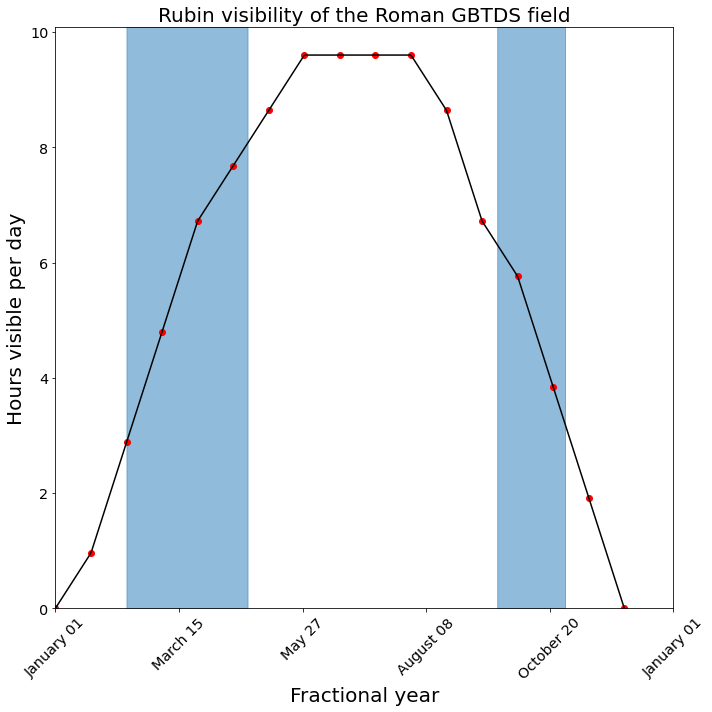

In [18]:
#bulge_visibility_samp = rubin_visibility_samp[bulge_pixels,:]
rubin_vis_func = interpolate.interp1d(dates_samp, bulge_visibility_samp)

ts2 = np.linspace(dates_samp.min(), dates_samp.max(), 365)
y = rubin_vis_func(ts2)

fontsize = 20
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.plot(dates_samp, bulge_visibility_samp, 'ro')
plt.plot(ts2, y, 'k-')
(xmin, xmax, ymin, ymax) = plt.axis()
for season in roman_survey.seasons:
    int_year = int(season['start'].decimalyear)
    day_start = season['start'].decimalyear - int_year
    day_end = season['end'].decimalyear - int_year
    x = np.array([day_start, day_end])
    y1 = np.array([ymin, ymin])
    y2 = np.array([ymax, ymax])
    ax.fill_between(x, y1, y2, alpha=0.2, color='C0')
    
plt.xlabel('Fractional year', fontsize=fontsize)
plt.ylabel('Hours visible per day', fontsize=fontsize)
plt.title('Rubin visibility of the Roman GBTDS field', fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize='x-large')
ax.yaxis.set_tick_params(labelsize='x-large')

plt.axis([0.0,1.0,0.0, ymax])

#myFmt = mdates.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(myFmt)
xticks =  ax.get_xticks()
print(xticks)
xdates = []
for t in xticks:
    t2 = Time((2026 + t), format='decimalyear')
    t2.format = 'iso'
    t2 = datetime.strptime(str(t2).split()[0], '%Y-%m-%d')
    xdates.append(t2.strftime("%B %d"))

ax.set_xticklabels(xdates, rotation=45.0)
plt.tight_layout()

display = True
if display:
    plt.show()
else:
    plt.savefig('/Users/rstreet1/Roman/CoreSurveyWhitePaper/roman_rubin_annual_visibility.png')
    plt.close(1)